# CNN Baseline model

This notebook aims to provide a baseline CNN model for comparison with our auto-supervised approach to the deepfake audio detection.

The model choosed was [ConvNeXt-Tiny-AT](https://huggingface.co/topel/ConvNeXt-Tiny-AT). It is a CNN based audio model pretrained on the [AudioSet](http://research.google.com/audioset/index.html) dataset, to classify between 632 audio event classes in a collection of 2,084,320 human-labeled 10-second sound clips drawn from YouTube videos.

The model was pretrained on a supervised way, and will be fine-tuned also in a supervised way, to see how it compares with the self-supervised approach.

## Notebook setup

In [36]:
import os
import numpy as np
import pandas as pd
import torch
from torch.nn import functional as TF
import torchaudio
import torchaudio.functional as TAF
import pathlib

from audioset_convnext_inf.pytorch.convnext import ConvNeXt
from audioset_convnext_inf.utils.utilities import read_audioset_label_tags

PATH_TO_DATASET = "/home/elias/Projects/2024s2/MC959/AUDIOS/data/release_in_the_wild"

RANDOM_STATE = 7 # the biblical number of perfection =)

model = ConvNeXt.from_pretrained("topel/ConvNeXt-Tiny-AT", map_location='cpu')

print(
    "# params:",
    sum(param.numel() for param in model.parameters() if param.requires_grad),
)

if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

if "cuda" in str(device):
    model = model.to(device)

Using ckpt from HF
# params: 28222767


## Exploratory analysis

In [3]:
[x for x in os.listdir(PATH_TO_DATASET) if x.endswith('.csv')]

['meta.csv']

In [4]:
dataset_metadata_df = pd.read_csv(os.path.join(PATH_TO_DATASET, 'meta.csv'))
dataset_metadata_df.head()

,file,speaker,label
0,0.wav,Alec Guinness,spoof
1,1.wav,Alec Guinness,spoof
2,2.wav,Barack Obama,spoof
3,3.wav,Alec Guinness,spoof
4,4.wav,Christopher Hitchens,bona-fide


In [9]:
# load the durations of each audio
import librosa

# Function to get the duration
def get_duration(filename):
    try:
        audio_path = os.path.join(PATH_TO_DATASET, filename)
        y, sr = librosa.load(audio_path, sr=None)
        return librosa.get_duration(y=y, sr=sr)
    except Exception as e:
        print(f"Could not load file {filename}: {e}")
        return None

# Apply the function to get durations and add them as a new column
dataset_metadata_df['duration'] = dataset_metadata_df['file'].apply(get_duration)
print("duration of calculations done")

duration of calculations done


In [32]:
print("total audio clips:", dataset_metadata_df.duration.count())
print("mean duration of audio clips (seconds):", dataset_metadata_df.duration.mean())
print("N speakers:", dataset_metadata_df.speaker.nunique())
print("Total audio time (hours):", dataset_metadata_df.duration.sum() / 3600)

total audio clips: 31779
mean duration of audio clips (seconds): 4.287800174643633
N speakers: 54
Total audio time (hours): 37.850556041666664


In [20]:
print("audio samples per speaker")
dataset_metadata_df.speaker.value_counts()

audio samples per speaker


speaker
Barack Obama                3636
Alec Guinness               3625
Donald Trump                3423
Bernie Sanders              2877
Ayn Rand                    2493
Bill Clinton                1832
Ronald Reagan               1536
Christopher Hitchens        1339
Winston Churchill            882
Martin Luther King           799
JFK                          669
Milton Friedman              589
Mark Zuckerberg              582
FDR                          471
Queen Elizabeth II           464
Louis Farrakhan              410
Alexandria Ocasio-Cortez     390
Nelson Mandela               381
Alan Watts                   378
Richard Nixon                359
Arnold Schwarzenegger        351
The Notorious B.I.G.         329
Boris Johnson                295
Dwight Eisenhower            268
George Carlin                248
George W. Bush               230
Adam Driver                  217
Gilbert Gottfried            208
Orson Welles                 202
Bill Burr                    201
Ma

In [22]:
print('Minutes per speaker')
dataset_metadata_df.groupby("speaker")['duration'].sum().sort_values(ascending=False) / 60

Minutes per speaker


speaker
Alec Guinness               262.317996
Barack Obama                243.583371
Bernie Sanders              223.375725
Donald Trump                209.212338
Ayn Rand                    176.117699
Ronald Reagan               108.115453
Bill Clinton                103.826186
Christopher Hitchens         98.959503
Mark Zuckerberg              59.149473
Martin Luther King           53.843203
Winston Churchill            47.467244
Milton Friedman              45.847965
JFK                          38.828141
Alexandria Ocasio-Cortez     37.178624
Queen Elizabeth II           35.231076
FDR                          35.227219
Louis Farrakhan              29.047594
Gilbert Gottfried            23.865337
George Carlin                23.661968
Boris Johnson                23.626683
Bill Burr                    22.838548
Arnold Schwarzenegger        21.763503
Alan Watts                   21.689932
John Cleese                  21.624093
Richard Nixon                21.523980
Orson Welles     

In [23]:
print("samples by class")
dataset_metadata_df['label'].value_counts()

samples by class


label
bona-fide    19963
spoof        11816
Name: count, dtype: int64

In [24]:
print("minutes by class")
dataset_metadata_df.groupby("label")['duration'].sum().sort_values(ascending=False) / 60

minutes by class


label
bona-fide    1245.358597
spoof        1025.674766
Name: duration, dtype: float64

In [28]:
# the proportions of samples and duration are diferrent, why?
print("duration mean of each class")
print("mean duration of spoof audios is bigger")
dataset_metadata_df.groupby("label")['duration'].mean()

duration mean of each class
mean duration of spoof audios is bigger


label
bona-fide    3.743000
spoof        5.208233
Name: duration, dtype: float64

In [47]:
print("Quantity of each audio per speaker")

spoof_per_speaker = dataset_metadata_df[dataset_metadata_df.label == 'spoof'].groupby("speaker").duration.count()
bonafide_per_speaker = dataset_metadata_df[dataset_metadata_df.label == 'bona-fide'].groupby("speaker").duration.count()

# Combine into a single DataFrame
counts_df = pd.DataFrame({
    'spoof_count': spoof_per_speaker,
    'bona_fide_count': bonafide_per_speaker
}).fillna(0)  # Fill NaN with 0 if some speakers have no 'spoof' or 'bona-fide' samples

# Calculate total count and ratio for each speaker
counts_df['total'] = counts_df['spoof_count'] + counts_df['bona_fide_count']
counts_df['spoof_ratio'] = counts_df['spoof_count'] / counts_df['total']

counts_df.sort_values("spoof_ratio")

Quantity of each audio per speaker


,spoof_count,bona_fide_count,total,spoof_ratio
speaker,,,,
Donald Trump,155,3268,3423,0.045282
Nick Offerman,11,158,169,0.065089
Jeff Goldblum,4,56,60,0.066667
Barack Obama,334,3302,3636,0.091859
Lyndon Johnson,12,95,107,0.112150
Kamala Harris,4,25,29,0.137931
Calvin Coolidge,15,58,73,0.205479
Dwight Eisenhower,63,205,268,0.235075
Harry Truman,16,47,63,0.253968


In [57]:
print("Minutes of each audio per speaker")

import pandas as pd

# Sum durations for each label per speaker, converting to minutes
spoof_per_speaker = dataset_metadata_df[dataset_metadata_df.label == 'spoof'].groupby("speaker").duration.sum() / 60
bonafide_per_speaker = dataset_metadata_df[dataset_metadata_df.label == 'bona-fide'].groupby("speaker").duration.sum() / 60

# Combine into a single DataFrame
duration_df = pd.DataFrame({
    'spoof_duration (min)': spoof_per_speaker,
    'bona_fide_duration (min)': bonafide_per_speaker
}).fillna(0)  # Fill NaN with 0 if some speakers have no 'spoof' or 'bona-fide' samples

# Calculate total duration and ratio for each speaker
duration_df['total_duration (min)'] = duration_df['spoof_duration (min)'] + duration_df['bona_fide_duration (min)']
duration_df['spoof_ratio'] = duration_df['spoof_duration (min)'] / duration_df['total_duration (min)']

# Sort by spoof ratio
duration_df = duration_df.sort_values("spoof_ratio")

duration_df.sort_values("spoof_ratio")


Minutes of each audio per speaker


,spoof_duration (min),bona_fide_duration (min),total_duration (min),spoof_ratio
speaker,,,,
Donald Trump,13.816143,195.396195,209.212338,0.066039
Jeff Goldblum,0.500584,5.137945,5.638529,0.088779
Barack Obama,22.151278,221.432093,243.583371,0.090939
Nick Offerman,1.345788,9.537914,10.883701,0.123652
Kamala Harris,0.430552,2.103413,2.533965,0.169912
Robert Kardashian,1.309439,5.846300,7.155739,0.182991
Lyndon Johnson,1.801954,4.985355,6.787309,0.265489
Malcolm X,3.795770,9.966466,13.762235,0.275811
Harry Truman,1.674556,3.802586,5.477143,0.305735


## Dataset treatment

### Train val test split

## Model fine-tuning

### Making a simple prediction

In [80]:
def load_and_preprocess_audio(path_to_audio, sample_rate = 32000, target_seconds_length = 10):
    """Load an audio of the memory and preprocess it to be adequate to ConvNeXt model"""
    audio_target_length = target_seconds_length * sample_rate  # 10 s

    waveform, sample_rate_ = torchaudio.load(path_to_audio)
    if sample_rate_ != sample_rate:
        print("Resampling from %d to 32000 Hz"%sample_rate_)
        waveform = TAF.resample(
            waveform,
            sample_rate_,
            sample_rate,
            )

    if waveform.shape[-1] < audio_target_length:
        # padding waveform
        missing = max(audio_target_length - waveform.shape[-1], 0)
        waveform = TF.pad(waveform, (0,missing), mode="constant", value=0.0)
    elif waveform.shape[-1] > audio_target_length:
        # cropping waveform
        waveform = waveform[:, :audio_target_length]

    waveform = waveform.contiguous()
    
    return waveform

Resampling from 16000 to 32000 Hz


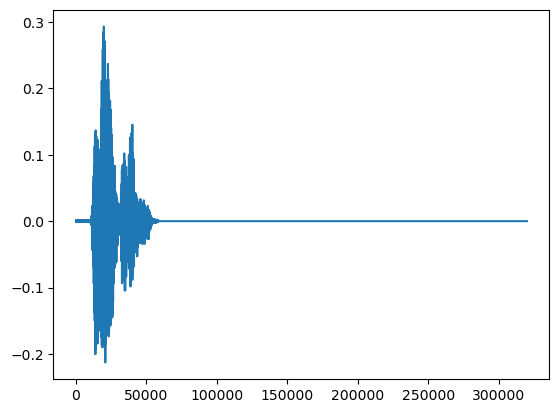

In [81]:
import matplotlib.pyplot as plt

sample_audio = dataset_metadata_df.file[0]
audio_path = os.path.join(PATH_TO_DATASET, sample_audio)

waveform = load_and_preprocess_audio(audio_path)

plt.plot(waveform[0])


In [82]:
waveform = waveform.to(device)

with torch.no_grad():
    model.eval()
    output = model(waveform)

logits = output["clipwise_logits"]
print("logits size:", logits.size())

probs = output["clipwise_output"]
# Equivalent: probs = torch.sigmoid(logits)
print("probs size:", probs.size())

lb_to_ix, ix_to_lb, id_to_ix, ix_to_id = read_audioset_label_tags('/home/elias/Projects/2024s2/MC959/AUDIOS/data/class_labels_indices_convnext.csv')

threshold = 0.1
sample_labels = np.where(probs[0].clone().detach().cpu() > threshold)[0]
print("\nPredicted labels using activity threshold 0.25:")
# print(sample_labels)
for l in sample_labels:
    print("    %s: %.3f"%(ix_to_lb[l], probs[0,l]))

logits size: torch.Size([1, 527])
probs size: torch.Size([1, 527])

Predicted labels using activity threshold 0.25:
    Speech: 0.877
    Male speech, man speaking: 0.146
    Speech synthesizer: 0.552


### Dataset and dataloader

### Model architecture adaptation

### Model training

### Model evaluation